# Comparison of two CNN
- Tadhg Ryan 21310408
- Szymon Szulc 21323208

##### Code executes to end with no errors

## Resources:
- Tensorflow Docs 2.10 https://www.tensorflow.org/versions/r2.10/api_docs
- Keras Docs 2.10 https://faroit.com/keras-docs/2.1.0/

## Set-up resources:
Data-set: Rice Image Dataset
https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

Anaconda was used to create the tf_env1 environment, ensuring the correct dependencies and GPU compatibility for TensorFlow.
https://docs.anaconda.com/

TensorFlow version 2.10 as it is the last supported version that allows you to run on GPU. 
https://www.tensorflow.org/versions/r2.10/api_docs

CUDA toolkit version 11.1 as this was the last version that worked with TensorFlow 2.10.
https://developer.nvidia.com/cuda-11.2.2-download-archive

cuDNN version 8.1 which is compatible with TensorFlow and CUDA toolkit.
https://developer.nvidia.com/rdp/cudnn-archive

## Disclaimer: 
This was built and ran using Windows 10, with an RTX 3070 using Tensorflow V2.10. Because of limitations with support for this we were unable to use 
newer features and training had to be limited. One of the features is the Lion optimiser which we would of liked to use. 


In [ ]:
import tensorflow as tf
# Shows Tensorflow version and GPU available, for debugging purposes

print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.17.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import kagglehub

# Manually looked through the dataset to find outliers and biases, found little to none therefore we are not editing it.
# Download latest version and add the path to get inside it, if on Linux use "/", Windows uses "\\"
dataset_path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset") + "\\Rice_Image_Dataset"

print("Path to dataset files:", dataset_path)


100%|██████████| 219M/219M [00:01<00:00, 149MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset


In [ ]:
# Hyperparameters

# Learning takes place at the end of each batch, has to load all images in batch in memory,
# 	This means that higher batch size leads to more generalised learning and quick convergence but uses more memory
# 	While lower batch size uses less but is more susceptible to bias and outliers
BATCH_SIZE = 128

IMG_HEIGHT = 250
IMG_WIDTH = 250

# Number of K-Fold Cross Validation happening for each model, higher number will lead to more models being trained and possibly finding the global maxima, but a lot longer run time.
K = 3

# Number of epochs (times the model is trained on the dataset) per fold per model. Higher epochs is needed for convergence but we found 10 was a balance between run time and output.
EPOCHS = 10

# How much the model will learn, higher numbers can lead to overshooting the global minima while lower will cause convergence to take too long or possibly get stuck in a local minima.
LEARNING_RATE = 0.001

# The amount of images we are using out of our dataset, 75000 total images. Too low number could lead to underfitting but this is highly correlated with runtime.
MAX_SIZE_DATASET = 5000
NUM_OF_BATCHES = MAX_SIZE_DATASET // BATCH_SIZE

# Resizing the the size the models use.
RESIZED_SIZE = 224

In [ ]:
# Load data in
import tensorflow as tf

# Create the train dataset and test dataset, train will be split in the k fold to train/val datasets. Test will be used to evaluate the models at the end.
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=True,
    validation_split=0.004,
    subset="both",
    seed=42
)

# Get class names for later use
class_names = train_dataset.class_names

# Taking the subset of images as defined above
train_dataset = train_dataset.take(NUM_OF_BATCHES)
print(f"Taking {NUM_OF_BATCHES} batches")


Found 75000 files belonging to 5 classes.
Using 74700 files for training.
Using 300 files for validation.
Taking 39 batches


Count: Counter({'Basmati': 1025, 'Ipsala': 1000, 'Arborio': 999, 'Karacadag': 999, 'Jasmine': 969})


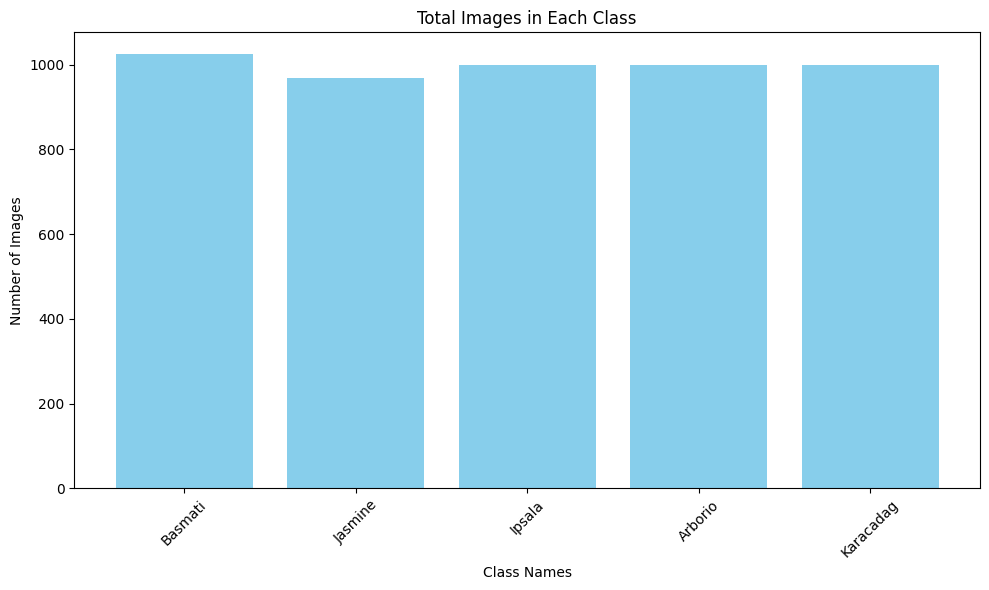

In [ ]:
# Print out number of images in each class
# This ensure that no class is too dominant in the dataset as all should have an even split
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter()

for images, labels in train_dataset:
    class_counts.update([class_names[label] for label in labels.numpy()])

print(f"Count: {class_counts}")

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Total Images in Each Class")
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Data Augmentation
from tensorflow.keras import layers

# Define the data augmentation pipeline, helps with generalisation and prevent overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(-0.2, 0.2),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(factor=(-0.2, 0.2)),
])
# Define the scaling pipeline to rescale to size needed
data_scaling = tf.keras.Sequential([
    layers.Resizing(RESIZED_SIZE, RESIZED_SIZE)
])
# Normalize all the data, as large values will cause learning to slow down, normalize to 0-1
data_normalisation = tf.keras.Sequential([
    layers.Rescaling(1./255),
])

# Define functions to apply the augmentation
def augment_image(image, label):
    image = data_augmentation(image, training=True)
    return image, label

def scale_image(image, label):
    image = data_scaling(image, training=True)
    return image, label

def normalise_image(image, label):
    image = data_normalisation(image)
    return image, label

# We are not creating our own data as our dataset size is quite large (75000) and we are only training on a subset of this amount.


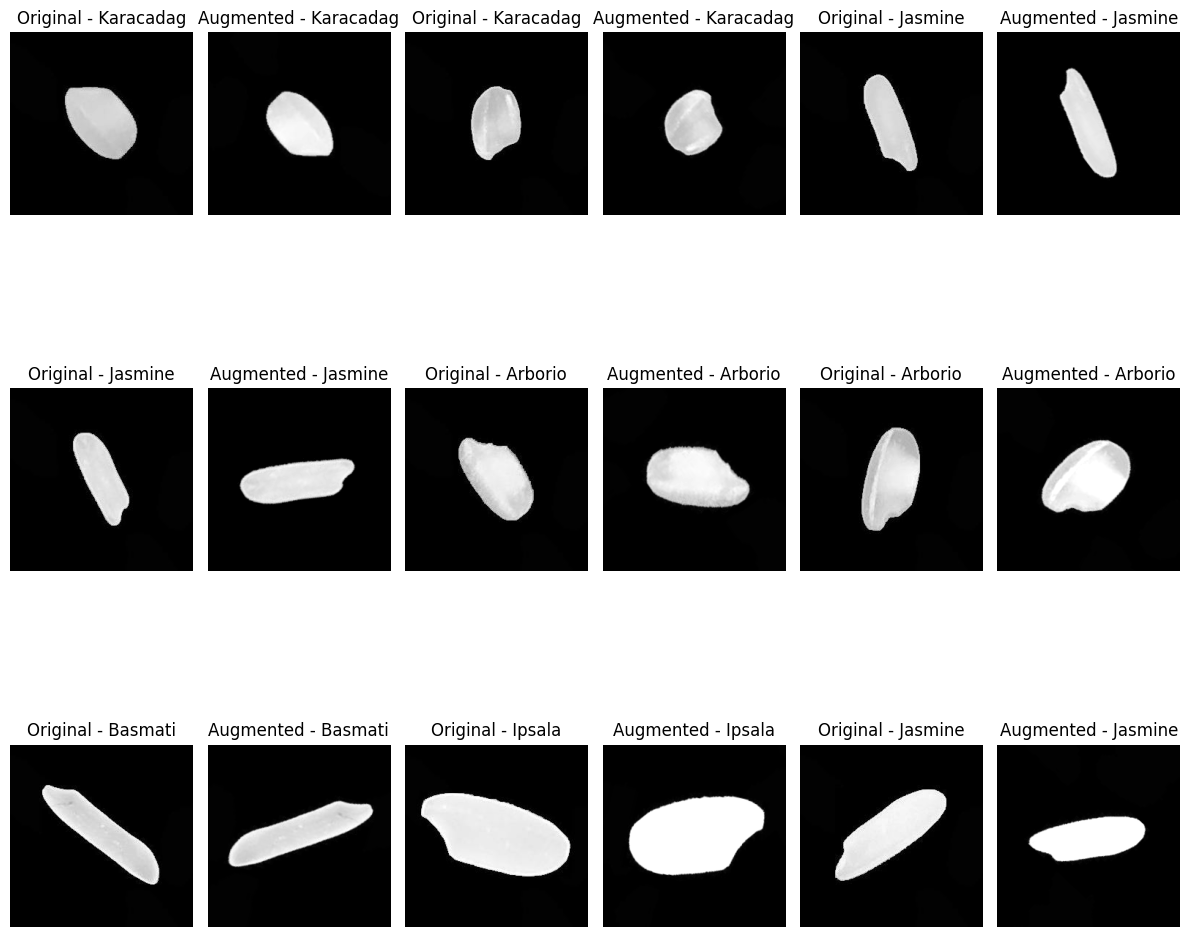

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Number of images to show original vs augmented
num_images = 9

original_images = []
augmented_images = []
labels_list = []

i = 0
for image_batch, label_batch in train_dataset:
    if i >= num_images:
        break
    original_images.append(normalise_image(image_batch, None)[0])
    augmented_image = augment_image(image_batch, None)[0]
    augmented_image = scale_image(augmented_image, None)[0]
    augmented_image = normalise_image(augmented_image, None)[0]
    augmented_images.append(augmented_image)
    labels_list.append(label_batch)
    i += BATCH_SIZE

original_images_array = tf.concat(original_images, axis=0)
augmented_images_array = tf.concat(augmented_images, axis=0)
labels_array = tf.concat(labels_list, axis=0)

original_images_to_display = original_images_array[:num_images]
augmented_images_to_display = augmented_images_array[:num_images]
labels_to_display = labels_array[:num_images]

plt.figure(figsize=(12, 12))

for i in range(num_images):
    ax = plt.subplot(3, 6, 2 * i + 1)
    plt.imshow(original_images_to_display[i].numpy().squeeze())
    plt.title(f"Original - {class_names[labels_to_display[i].numpy()]}")
    plt.axis("off")

    ax = plt.subplot(3, 6, 2 * i + 2)
    plt.imshow(augmented_images_to_display[i].numpy().squeeze())
    plt.title(f"Augmented - {class_names[labels_to_display[i].numpy()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Augments, scales and normalises the training dataset, augments to generalise and prevent overfitting
augmented_train_dataset         = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
scale_augmented_train_dataset   = augmented_train_dataset.map(scale_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset                   = scale_augmented_train_dataset.map(normalise_image, num_parallel_calls=tf.data.AUTOTUNE)


# Scales and normalises the test dataset, this is to make it run through the models without issues
scale_test_dataset              = test_dataset.map(scale_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset                    = scale_test_dataset.map(normalise_image, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Create Inception V3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

def makeInceptionV3(input_shape=(224, 224, 3), num_classes=5, dropout_rate=0.5):
	model = models.Sequential([])
	model.add(layers.Input(shape=input_shape))

	# Using weights from image net, this is using a pretrained model so that the work on our end is less as we can use these pretrained weights
	# We are not including the top as we are including it in our model
	inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

	# Freezing the layers as we will unfreeze later on during training
	for layer in inceptionV3.layers:
		layer.trainable = False

	model.add(inceptionV3)
 
	# Fully connected layers to interprete Inception V3 as this base model was trained on roughly 1000 classifications. 
	model.add(layers.Flatten())
	model.add(layers.Dense(128, activation='relu'))
	model.add(layers.BatchNormalization()) # BN is used to increase stabilisation and generalisation by normalizing and scaling.
	model.add(layers.Dropout(dropout_rate)) # Dropout to help with overfitting and generalisation
	model.add(layers.Dense(num_classes, activation='softmax')) # Softmax as we have a multi-class classification, sigmoid is used for binary classification.

	return model, inceptionV3 # return full and base model as we will be only unfreezing the base model (so we need reference to it). 

makeInceptionV3()[0].summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,357,669 (108.18 MB)

 Trainable params: 6,554,629 (25.00 MB)

 Non-trainable params: 21,803,040 (83.17 MB)

In [ ]:
# Define ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf

def makeResNet50(input_shape=(224, 224, 3), num_classes=5, dropout_rate=0.5):
	# Using weights from image net, this is using a pretrained model so that the work on our end is less as we can use these pretrained weights
	# We are not including the top as we are including it in our model
    base_model = ResNet50(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )

    model = models.Sequential()
    model.add(layers.Input(input_shape))

	# Freezing the layers as we will unfreeze later on during training
    for layer in base_model.layers:
        layer.trainable = False

    model.add(base_model)
    
	# Fully connected layers to interprete Inception V3 as this base model was trained on roughly 1000 classifications. 
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.BatchNormalization()) # BN is used to increase stabilisation and generalisation by normalizing and scaling.
    model.add(layers.Dropout(dropout_rate)) # Dropout to help with overfitting and generalisation
    model.add(layers.Dense(num_classes, activation="softmax")) # Softmax as we have a multi-class classification, sigmoid is used for binary classification.

    return model, base_model # return full and base model as we will be only unfreezing the base model (so we need reference to it). 

makeResNet50()[0].summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,434,053 (138.98 MB)

 Trainable params: 12,846,085 (49.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [ ]:
# Callback for unfreezing and reducing learning rate
# We unfreeze and reduce learning rate to not mess up the pretrained weights, but we still want to slowly learn as our 
# 	classification is different from the one it was originally trained on.
class UnfreezeAndReduceLRCallback(tf.keras.callbacks.Callback):
	def __init__(self, base_model, unfreeze_layers=2, reduce_lr_factor=0.5, trigger_epoch=3, layers_unfrozen=0):
		super().__init__()
		self.base_model = base_model
		self.unfreeze_layers = unfreeze_layers
		self.reduce_lr_factor = reduce_lr_factor
		self.trigger_epoch = trigger_epoch
		self.layers_unfrozen = layers_unfrozen

	def on_epoch_begin(self, epoch, logs=None):
		if epoch == self.trigger_epoch-1:
			total_layers = len(self.base_model.layers)
			for layer in self.base_model.layers[-self.unfreeze_layers + self.layers_unfrozen:]:
				layer.trainable = True
			print(f"Unfroze the last {self.unfreeze_layers + self.layers_unfrozen} layers out of {total_layers} layers.")
			self.layers_unfrozen += self.unfreeze_layers

			current_lr = self.model.optimizer.learning_rate.numpy()
			new_lr = current_lr * self.reduce_lr_factor
			self.model.optimizer.learning_rate.assign(new_lr)
			print(f"Reduced learning rate from {current_lr:.6f} to {new_lr:.6f}.")


In [ ]:
# Defining k-fold cross validation
# Because we are using a tf.data.dataset and not a numpy tensor, we cannot do Kfold the normal way. 
# 	We are forced to split based on the index and split the data into train/val datasets. 

# We are using K-Fold to help with finding the best model. It runs it multiple times.
# One thing we could do is to change the hyperparameters to see how that effects it here. 
from sklearn.model_selection import KFold
import numpy as np

def RunKFold(modelFunction, optimiser_class, loss_function, callbacks):
	kf = KFold(n_splits=K, shuffle=True)

	# Get a list of all the indexes for the dataset. 
	indices = np.arange(len(train_dataset))

	# Keep track of best model depending on the validation loss.
	best_model = None
	best_val_loss = float('inf')

	for fold, (train_index, val_index) in enumerate(kf.split(indices)):
		print(f"==================== Fold: {fold+1} ====================")
		train = train_dataset.skip(train_index[0]).take(1)
		for index in train_index[1:]:
			train = ((train_dataset.skip(index)).take(1)).concatenate(train)
		train.cache().prefetch(tf.data.AUTOTUNE)

		val = train_dataset.skip(val_index[0]).take(1)
		for index in val_index[1:]:
			val = ((train_dataset.skip(index)).take(1)).concatenate(val)
		val.cache().prefetch(tf.data.AUTOTUNE)

  		# Recreate the model to avoid reusing weights
		model, baseModel = modelFunction(input_shape=(RESIZED_SIZE, RESIZED_SIZE, 1), num_classes=len(class_names))

		optimiser = optimiser_class(learning_rate=LEARNING_RATE)

		# Compile the model
		model.compile(optimizer=optimiser, loss=loss_function, metrics=['accuracy'])

		unfreezeAndReduceLRCallback = UnfreezeAndReduceLRCallback(baseModel)
		callbacks.append(unfreezeAndReduceLRCallback)
  
		# Train the model and keep the history
		history = model.fit(train, epochs=EPOCHS, validation_data=val, callbacks=callbacks)
		val_loss = min(model.history.history['val_loss'])
  
		# Update the best model if this fold is better. This will be used then for evaluating the performance of this whole model
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			best_model = model
			model.history_data = history.history

	return best_model



In [ ]:
# Run Models with k-fold cross validation
from tensorflow.keras import optimizers, losses, callbacks

# Caching and prefetching to help with performance
# tf.data.dataset will load only the data it needs into memory,
# 	prefetching will load the next data (and augment etc) so that there is no slow down while fetching data.
train_dataset.cache().prefetch(tf.data.AUTOTUNE)

ModelFunctions = [makeInceptionV3, makeResNet50]
ModelNames = ["InceptionV3", "ResNet50"]

bestModels = []
for model in ModelFunctions:
	# Early stopping based on validation loss if plateaus for 5 epochs. This to help speed up runtime.
	callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
 
	# Using Adam optimiser as it converges and performs the best. We tested others such as SGD and RMSProp but Adam outperformed them. 
	# Wanted to test Lion but is on newer version of Keras that we couldn't access if we ran on our own GPU.
	optimiser = optimizers.Adam
 
	# Using Sparse Categorical CrossEntropy because we have multi-class labels that are not one hot-encoded. 
	# Tested One hot encoded categorical crossentropy but performed worse overall. 
	loss_function = losses.SparseCategoricalCrossentropy(from_logits=False)
 
	print(f"============================================== {ModelNames[len(bestModels)]} Model ==============================================")
	bestModels.append(RunKFold(model, optimiser, loss_function, callbacks))


============================================== InceptionV3 Model ==============================================
==================== Fold: 1 ====================
Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.7487 - loss: 0.7414 - val_accuracy: 0.8846 - val_loss: 0.6357
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.8909 - loss: 0.2855 - val_accuracy: 0.9303 - val_loss: 0.2307
Unfroze the last 2 layers out of 311 layers.
Reduced learning rate from 0.001000 to 0.000500.
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.9202 - loss: 0.2381 - val_accuracy: 0.9303 - val_loss: 0.2257
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.9070 - loss: 0.2508 - val_accuracy: 0.9405 - val_loss: 0.1800
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.9156 - loss: 0.2234 - val_accuracy: 0.9453 - val_loss: 0.1622
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.9288 - loss: 0.1938 - val_accuracy: 0.9567 -

================ Metrics for InceptionV3 Model ================


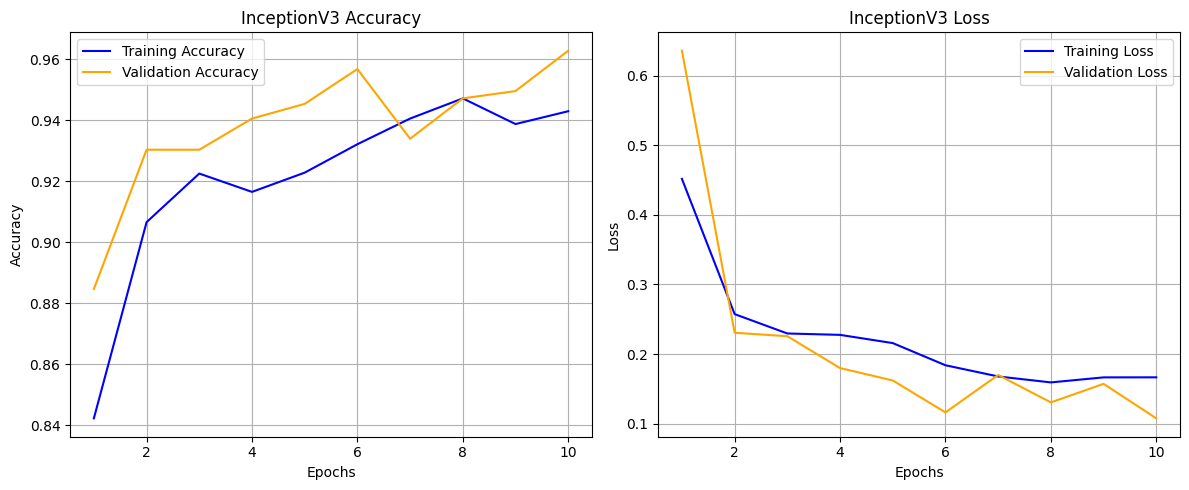

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


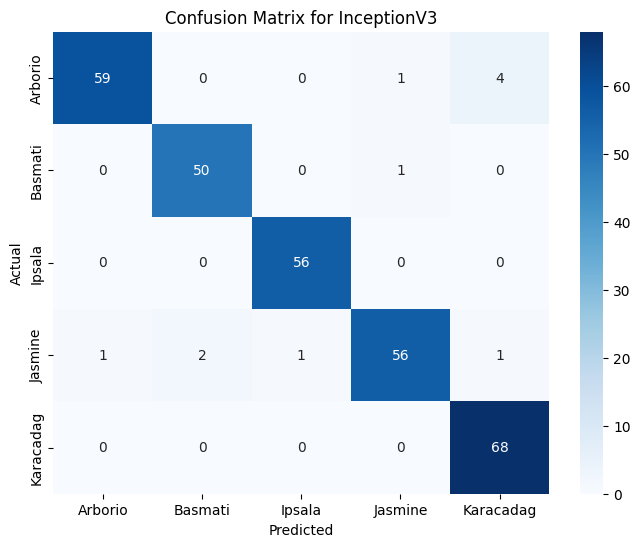

Accuracy: 0.9633


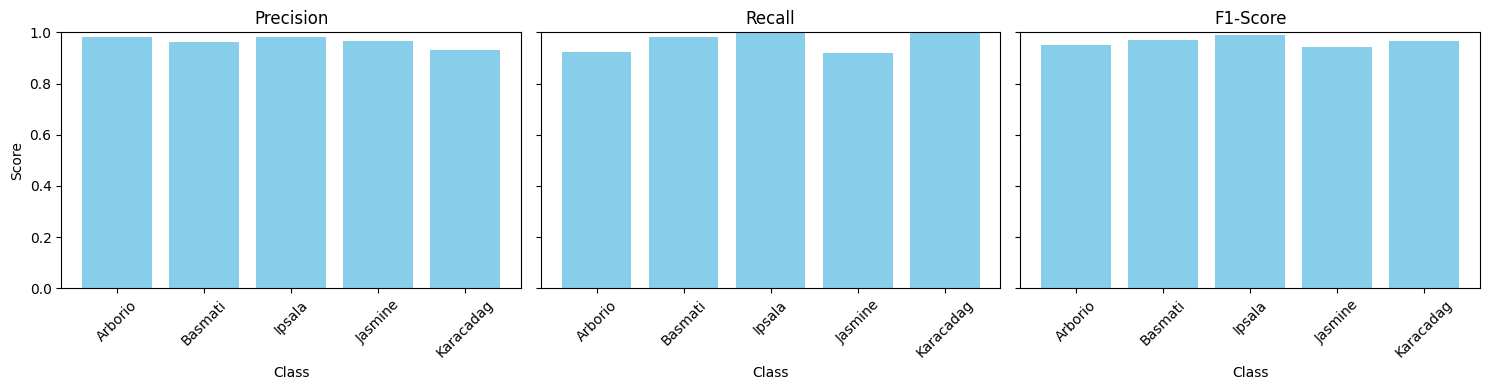


================ Metrics for ResNet50 Model ================


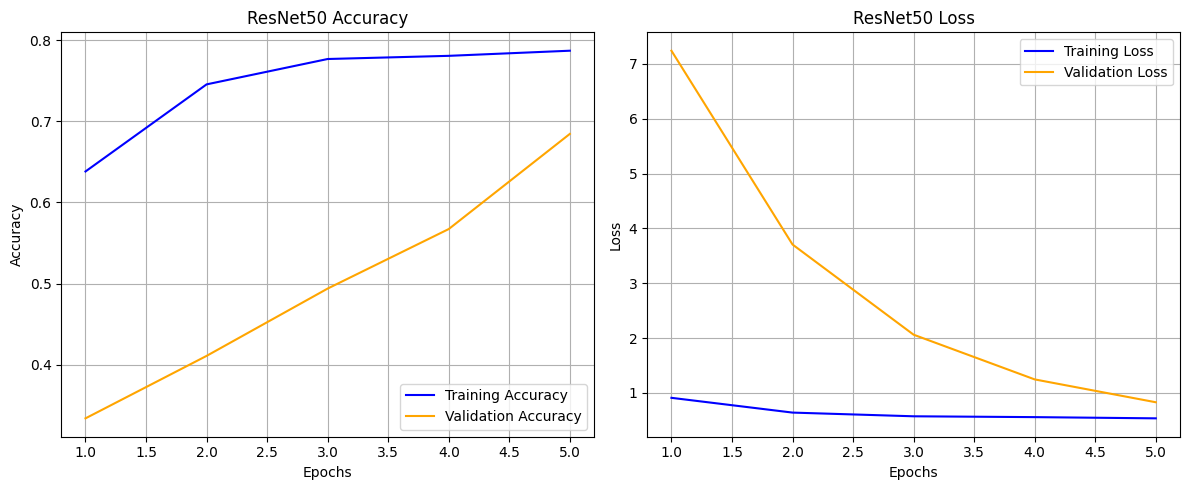

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


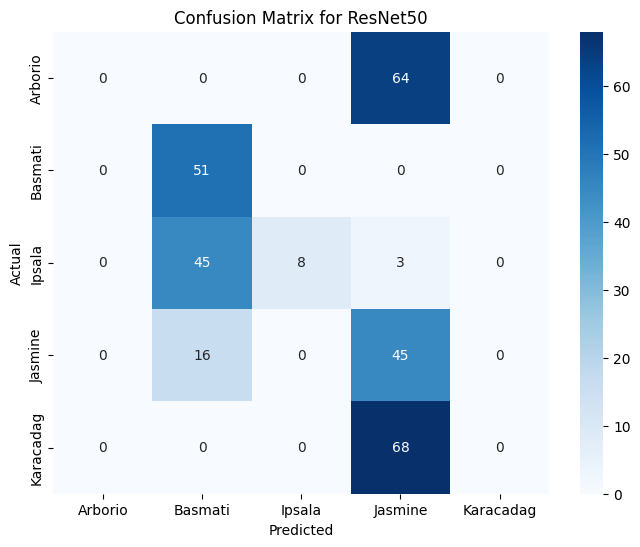

Accuracy: 0.3467


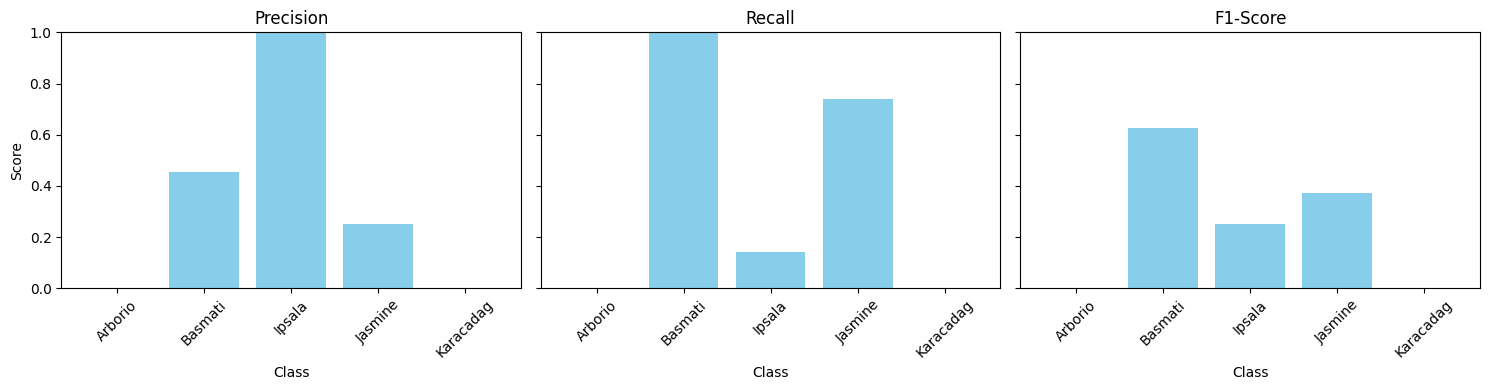

In [ ]:
# Calculate and display metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import numpy as np

def plot_training_history(history, model_name):
    # Plots accuracy and loss graphs from the training history.
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def evaluate_models(models, test_dataset, class_names):
    for i, model in enumerate(models):
        print(f"================ Metrics for {ModelNames[i]} Model ================")

        plot_training_history(model.history_data, ModelNames[i])

        # Collect predictions
        y_true = []
        y_pred = []
        for images, labels in test_dataset:
            y_true.extend(labels.numpy())
            predictions = model.predict(images)
            y_pred.extend(np.argmax(predictions, axis=1))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix for {ModelNames[i]}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Gather precision, recall and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        print(f"Accuracy: {accuracy:.4f}")

        # Bar charts for metrics above
        metrics = [precision, recall, f1]
        metric_names = ["Precision", "Recall", "F1-Score"]

        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        for ax, metric, name in zip(axes, metrics, metric_names):
            ax.bar(class_names, metric, color='skyblue')
            ax.set_title(name)
            ax.set_ylim(0, 1)
            ax.set_xlabel("Class")
            ax.tick_params(axis='x', rotation=45)
        axes[0].set_ylabel("Score")

        plt.tight_layout()
        plt.show()

        print("======================================================\n")

evaluate_models(bestModels, test_dataset, class_names)


# Inception V3
The accuracy and loss graphs demonstrate that while the metrics were somewhat jumpy, they were clearly converging. With more epochs and/or larger batches for training, Inception V3 would have likely settled and reached a high accuracy rate with minimal overfitting. The confusion matrix, along with precision, recall, and F1-score charts, highlight that the model classified the data well without a bias toward false negatives or false positives. This indicates balanced performance across all categories. The primary limiting factor was the truncation of training, as hardware constraints prevented further optimization.

# ResNet50
In comparison, the accuracy and loss graphs for ResNet50 show convergence starting to occur, but the model's training was halted prematurely. This was due to a combination of using fewer epochs and a smaller dataset size. These constraints led to underfitting, as observed in the confusion matrix and bar charts, where the model leaned heavily toward predicting certain classes, such as basmati and jasmine. These tendencies emphasize the need for longer training and a larger dataset to achieve better generalization in future experiments.

# Conclusion
Inception V3 emerged as the superior model for classifying rice, demonstrating faster convergence and higher accuracy. ResNet50, while promising, was hindered by insufficient training iterations and data volume, resulting in underfitting. Moving forward, we would address these limitations by leveraging a larger dataset, increasing epochs, and integrating a hyperparameter tuner to identify the optimal settings. Although constrained by hardware capabilities, such as the memory limits of an RTX 3070 GPU, our findings indicate that Inception V3 is the more effective architecture for this task.

# Extra
When deciding which model to use for our rice image classification, we evaluated InceptionV3, ResNet50, and VGG19, using pre-trained weights with frozen initial layers on our dataset. VGG19 demonstrated slower convergence to the global minima, resulting in poorer performance compared to the other models. On the other hand, InceptionV3 and ResNet50 proved more effective, and converged faster. Despite the hardware constraints of using an RTX 3070 for all models, both InceptionV3 and ResNet50 consistently outperformed VGG19 in terms of convergence speed and accuracy, making them better suited for our dataset.